In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

- APPLICATION_TRAIN 데이터를 활용하여 기본 모델링(version_1)

- 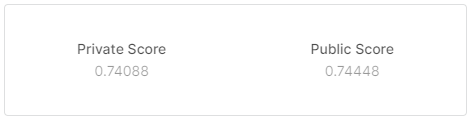

- APPLICATION_TRAIN 데이터를 활용하여 기본 모델링(version_2)
- APPLICATION_TRAIN의 EXT_SOURCE, 대출 금액 관련 FEATURE, AMT_INCOME_TOTAL, DAYS_BIRTH, DAYS_EMPLOYED 기반 FEATURE ENGINEERING 수행
- 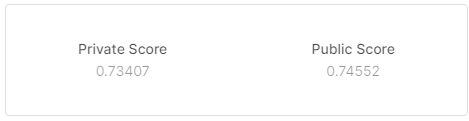

- 지난 수업에 주요 feature
- 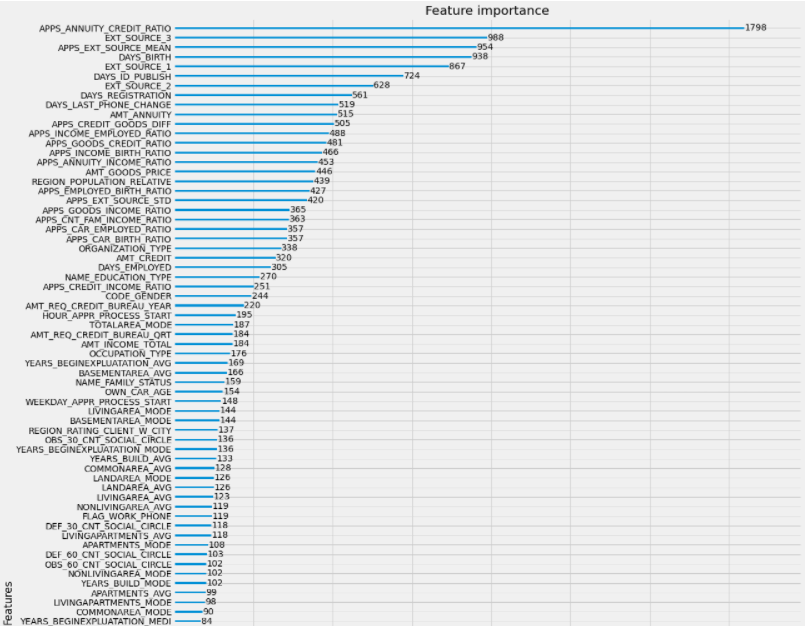

## VERSION_3
### prev_application 데이터 세트 기반의 EDA와 Feature Engineering 수행 후 학습 모델 생성/평가
- PREVIOUS_APPLICATION.CSV - 과거 대출 이력 (고객의 현재 대출 이전 과거 대출 정보 제공) 

### 라이브러리 및 데이터 세트 로딩

In [ ]:
import numpy as np
import pandas as pd
import gc
import time

%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

### 새로운 FEATURE 만들어서 APPLICATION_TRAIN 과 APPLICATION_TEST에 추가

In [ ]:
app_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')

In [ ]:
# app_train 과 app_test를 함께 가공을 해야하기 때문에 concat 이용하여 통합

apps = pd.concat([app_train, app_test])

In [ ]:
print('Size of application_train data', app_train.shape)
print('Size of application_test data', app_test.shape)
print('Size of apps', apps.shape)

#### VERSION_2에서 FEATURE ENGINEERING 복사 --> 함수로 가공

In [ ]:
def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 대출 금액 관련 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 소득/자산 관련 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

### PREVIOUS_APPLICATION 로딩

In [ ]:
prev_app = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')
print(prev_app.shape, apps.shape)

In [ ]:
prev_app.head()

### APPLICATION 과 PREVIOUS 조인 하고 비교 (누락된 집합들 확인)
- APPLICATION --> SK_ID_CURR (현재 대출 신청 사람)
- PREVIOUS --> SK_ID_PREV (현재 대출 신청 사람에 대한 과거 대출기록)
- = 그러나, 신청하는 모든 사람에 대한 과거 대출기록이 있지 않음

In [ ]:
# MERGE 사용하여 조인
# 파라미터: how='outer' --> 두 데이터셋에 대한 모든 데이터를 조인하는 Outter 조인
# inner 조인은 --> 두 데이터셋 간의 중복된 요소만을 조인하는 Inner 조인
# indicator 파라미터 --> 어느 쪽이 누락이 되어있는지 알수 있음

prev_app_outer = prev_app.merge(apps['SK_ID_CURR'], on='SK_ID_CURR', how='outer', indicator=True)

In [ ]:
prev_app_outer.head()

In [ ]:
prev_app_outer['_merge'].value_counts()

### prev_app 컬럼과 Null 값 확인

In [ ]:
# Null 값을 확인하고 전체 데이터에서 비율을 보여주는 함수

def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [ ]:
prev_app.info()

In [ ]:
missing_data(prev_app).head(20)

### SK_ID_CURR당 평균 SK_ID_PREV 건수 확인
- groupby로 평균 건수 구함
- boxplot으로 시각화

In [ ]:
prev_app.groupby('SK_ID_CURR').count()

In [ ]:
prev_app.groupby('SK_ID_CURR')['SK_ID_CURR'].count()#.mean()

In [ ]:
# 시각화

sns.boxplot(prev_app.groupby('SK_ID_CURR')['SK_ID_CURR'].count())

### TARGET 유형에 따라 숫자형 피처들의 Histogram을 통해 확인
- application_train의 TARGET 값을 가져오기 위해 prev_app와 app_train을 조인 후 TARGET 유형에 따라 비교
- 숫자형 컬럼명 필터링

In [ ]:
# prev_app와 app_train을 inner 조인 ==> TARGET 값은 application_train(app_train) 데이터에만 있음
# ==> prev_app안에 TARGET 유형에 따라 FEATURE 확인을 하려면 조인할 필요가 있음

# app_train[['SK_ID_CURR', 'TARGET']] 두가지 컬럼만 갖고 옴
# on='SK_ID_CURR' 컬럼 기준으로 조인

app_prev_target = prev_app.merge(app_train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
app_prev_target.shape

In [ ]:
# 지난 시간에 사용한 함수 그대로 사용
# TARGET 1 일때 값을 확인
# TARGET 0 일때 값을 확인

def show_hist_by_target(df, columns):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), squeeze=False)
        sns.violinplot(x='TARGET', y=column, data=df, ax=axs[0][0] )
        sns.distplot(df[cond_0][column], ax=axs[0][1], label='0', color='blue')
        sns.distplot(df[cond_1][column], ax=axs[0][1], label='1', color='red')   

In [ ]:
# 숫자형 dtype 갖고 있는 컬럼만 추출

num_columns = app_prev_target.dtypes[app_prev_target.dtypes != 'object'].index.tolist()
num_columns

In [ ]:
# 'SK_ID_PREV','SK_ID_CURR' , 'TARGET' 컬럼 필요없음

num_columns = [column for column in num_columns if column not in ['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']]
num_columns

In [ ]:
# 시각화를 위해 show_hist_by_target 함수 호출

show_hist_by_target(app_prev_target, num_columns)

In [ ]:
num_columns

In [ ]:
app_prev_target.TARGET.value_counts()#(normalize=True)

In [ ]:
# AMT_ANNUITY, AMT_CREDIT, AMT_APPLICATION, AMT_CREDIT는 TARGET=1일 경우에 소액 비율이 약간 높음(큰 차이는 아님)

print(app_prev_target.groupby('TARGET').agg({'AMT_ANNUITY': ['mean', 'median', 'count']}))
print(app_prev_target.groupby('TARGET').agg({'AMT_APPLICATION': ['mean', 'median', 'count']}))
print(app_prev_target.groupby('TARGET').agg({'AMT_CREDIT': ['mean', 'median', 'count']}))

### TARGET 유형에 따라 Category 피처들의 Histogram을 비교

In [ ]:
object_columns = app_prev_target.dtypes[app_prev_target.dtypes=='object'].index.tolist()
object_columns

In [ ]:
# category type 을 위한 시각화 함수

def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col="TARGET", data=df, kind="count")
        chart.set_xticklabels(rotation=65)

In [ ]:
show_category_by_target(app_prev_target, object_columns)

- NAME_CONTRACT_TYPE은 TARGET=1일때 CASH_LOAN의 비중이 약간 높음
- NAME_CONTRACT_STATUS(대출허가상태)는 TARGET=1일때 상대적으로 TARGET=0 대비 (당연히) Refused의 비율이 높음
- NAME_PAYMENT_TYPE(대출납부방법)는 TARGET=1일때 상대적으로 TARGET=0 대비 XNA의 비율이 약간 높음

In [ ]:
pd.crosstab(app_prev_target.TARGET, app_prev_target.NAME_CONTRACT_TYPE, dropna=False, normalize='all')

In [ ]:
pd.crosstab(app_prev_target.TARGET, app_prev_target.NAME_CONTRACT_STATUS, dropna=False, normalize='all')

In [ ]:
pd.crosstab(app_prev_target.NAME_CONTRACT_TYPE, app_prev_target.NAME_CONTRACT_STATUS, dropna=False)

In [ ]:
# 'AMT_ANNUITY' : 월 대출 지급액
app_prev_target.groupby(['NAME_CONTRACT_TYPE', 'NAME_GOODS_CATEGORY']).agg({'AMT_ANNUITY': ['mean', 'median', 'count', 'max']})

In [ ]:
# groupby 이용하여 더 많은 feature 추출할 수 있음
# 예) 직업에 따른 월급...교육과 직업...대부분 대출은 누가 받을까요...같은 feature 추출할 수 있음

app_train.groupby(['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE']).agg({'AMT_INCOME_TOTAL': ['mean', 'median', 'count', 'max']})

# app_prev 데이터 세트 feature engineering 수행
- pandas groupby 단일 aggregation 함수 사용  
    - groupby SK_ID_CURR
    - SK_ID_CURR별 건수, AMT_CREDIT에 대한 평균, 최대 값

In [ ]:
# groupby SK_ID_CURR
# 
prev_app.groupby('SK_ID_CURR')

In [ ]:
# 변수로 받아서 prev_group에 저장
prev_group = prev_app.groupby('SK_ID_CURR') # groupby 대상 컬럼명
prev_group.head()

In [ ]:
prev_agg = pd.DataFrame()
prev_agg['CNT'] = prev_group['SK_ID_CURR'].count()
prev_agg.head()

In [ ]:
prev_agg['AVG_CREDIT'] = prev_group['AMT_CREDIT'].mean()
prev_agg['MAX_CREDIT'] = prev_group['AMT_CREDIT'].max()
prev_agg['MIN_CREDIT'] = prev_group['AMT_CREDIT'].min()

prev_agg.head()

In [ ]:
# groupby agg()함수를 이용하여 여러개의 aggregation 함수 적용

prev_group = prev_app.groupby('SK_ID_CURR')
prev_agg1 = prev_group['AMT_CREDIT'].agg(['mean', 'max', 'min'])
prev_agg2 = prev_group['AMT_ANNUITY'].agg(['mean', 'max', 'min'])

prev_agg = prev_agg1.merge(prev_agg2, on='SK_ID_CURR', how='inner')
prev_agg.head()

### agg()에 dictionary를 이용하여 groupby 적용

In [ ]:
agg_dict = {
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum']
}

prev_group = prev_app.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)
prev_amt_agg.head()

### grouby agg 로 만들어진 Multi index(계층 구조) 컬럼 변경
- MultiIndex로 되어 있는 컬럼명 확인
- MultiIndex 컬럼명을 _로 연결하여 컬럼명 변경 -->  AMT_CREDIT_MEAN

In [ ]:
# MultiIndex로 되어 있는 컬럼명 확인

prev_amt_agg.columns

In [ ]:
# MultiIndex 컬럼명을 _로 연결하여 컬럼명 변경 
#--> prev_amt_agg.columns = ['PREV_' + ('_').join(column).upper() for column in prev_amt_agg.columns.ravel()]

# 위 코드의 과정을 설명 (같이 안 해도 됨)

#[column for column in prev_amt_agg.columns]                      # 1. 인덱스가 list 형태로 바뀜
#[(column [0], column[1]) for column in prev_amt_agg.columns]     # 2. 결국에 SK_ID_CURR 컬럼은 [0] 번, count 컬럼은 [1] 번임
#[column [0]+'_'+column[1] for column in prev_amt_agg.columns]  # 3. 이름을 하나로 변경
#[column [0]+'_'+column[1]. upper() for column in prev_amt_agg.columns]   # 4. 이름은 대문자로 변경 --> upper 사용


### join 방법을 사용해도 됨
## ex)
#('_<=>_').join(['test1', 'test2'])

#[ ('_').join(column).upper() for column in prev_amt_agg.columns]  # 5.join 방법 사용
#['PREV_' + ('_').join(column).upper() for column in prev_amt_agg.columns.ravel()]  # 6. PREV_ 추가

# ravel은 계층 인덱스를 리스트(1차원 배열(array))로 평평하게 펴주는 넘파이(numpy) 함수 

In [ ]:
prev_amt_agg.columns = ['PREV_' + ('_').join(column).upper() for column in prev_amt_agg.columns.ravel()]
prev_amt_agg.head()

### prev 피처 가공 / 대출 신청액 대비 다른 금액 차이 및 비율 생성

In [ ]:
prev_app['PREV_CREDIT_DIFF'] = prev_app['AMT_APPLICATION'] - prev_app['AMT_CREDIT']
prev_app['PREV_GOODS_DIFF'] = prev_app['AMT_APPLICATION'] - prev_app['AMT_GOODS_PRICE']
prev_app['PREV_CREDIT_APPL_RATIO'] = prev_app['AMT_CREDIT']/prev_app['AMT_APPLICATION']
prev_app['PREV_ANNUITY_APPL_RATIO'] = prev_app['AMT_ANNUITY']/prev_app['AMT_APPLICATION']
prev_app['PREV_GOODS_APPL_RATIO'] = prev_app['AMT_GOODS_PRICE']/prev_app['AMT_APPLICATION']

### DAYS_XXX 피처의 365243 을 NULL로 변환하고, 첫번째 만기일과 마지막 만기일까지의 기간 가공

In [ ]:
prev_app['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev_app['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# 첫번째 만기일과 마지막 만기일까지의 기간
prev_app['PREV_DAYS_LAST_DUE_DIFF'] = prev_app['DAYS_LAST_DUE_1ST_VERSION'] - prev_app['DAYS_LAST_DUE']

#### 기존 이자율 관련 컬럼이 null이 많아서 새롭게 간단한 이자율을 대출 금액과 대출 금액 납부 횟수를 기반으로 계산
- CNT_PAYMENT는 전체 납부해야하는 횟수, AMT_ANNUITY 월 별 납부해야하는 금액 -> 이것으로 간단하게 이자율 계산

In [ ]:
prev_app.info()

In [ ]:
all_pay = prev_app['AMT_ANNUITY'] * prev_app['CNT_PAYMENT']
prev_app['PREV_INTERESTS_RATE'] = (all_pay/prev_app['AMT_CREDIT'] - 1)/prev_app['CNT_PAYMENT']

In [ ]:
prev_app.iloc[:, -7:].head(10)

### 기존 대출 금액, 대출 상태 관련 피처들과 이들을 가공하여 만들어진 새로운 컬럼들로 aggregation 수행

In [ ]:
agg_dict = {
     # 기존 컬럼. 
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    # 가공 컬럼
    'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
    'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
    'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
    'PREV_GOODS_APPL_RATIO':['mean', 'max'],
    'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
    'PREV_INTERESTS_RATE':['mean', 'max']
}

In [ ]:
agg_dict

In [ ]:
prev_group = prev_app.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)
prev_amt_agg.columns = ['PREV_'+('_').join(column).upper() for column in prev_amt_agg.columns.ravel()]

In [ ]:
prev_amt_agg.head()

In [ ]:
prev_amt_agg.shape

### SK_ID_CURR별로 NAME_CONTRACT_STATUS가 Refused 일 경우의 건수 및 과거 대출건 대비 비율
- Group by 기준 컬럼 기반에서 다른 컬럼들의 기준에 따라 세분화된 aggregation 수행

In [ ]:
prev_app['NAME_CONTRACT_STATUS'].value_counts()

In [ ]:
# SK_ID_CURR레벨로 groupby 된 count와 name_contract_status가 Refused일 때의 count
# NAME_CONTRACT_STATUS == 'Refused' 세부 기준으로 filtering 및 filtering 된 DataFrame에 groupby 적용

cond_refused = (prev_app['NAME_CONTRACT_STATUS'] == 'Refused')
prev_refused = prev_app[cond_refused]
prev_refused.shape, prev_app.shape

In [ ]:
# groupby 완료 후 기존 prev_amt_agg와 조인
prev_refused_agg = prev_refused.groupby('SK_ID_CURR')['SK_ID_CURR'].count()
prev_refused_agg.shape, prev_amt_agg.shape

In [ ]:
prev_refused_agg

In [ ]:
# 효율적인 오류 방지를 위해서 groupby 시 적용후 groupby key값을 DataFrame의 Index가 아닌 일반 컬럼으로 변경

pd.DataFrame(prev_refused_agg)

In [ ]:
prev_refused_agg.reset_index(name='PREV_REFUSED_COUNT')

In [ ]:
prev_refused_agg = prev_refused_agg.reset_index(name='PREV_REFUSED_COUNT')
prev_amt_agg = prev_amt_agg.reset_index()

prev_amt_refused_agg = prev_amt_agg.merge(prev_refused_agg, on='SK_ID_CURR', how='left')
prev_amt_refused_agg.head(10)

In [ ]:
prev_amt_refused_agg['PREV_REFUSED_COUNT'].value_counts(dropna=False)

### 계산된 PREV_REFUSED_COUNT 중 Null값은 0 으로 변경하고 SK_ID_CURR 개별 건수 대비 PREV_REFUSED_COUNT 비율 계산

In [ ]:
prev_amt_refused_agg = prev_amt_refused_agg.fillna(0)
prev_amt_refused_agg['PREV_REFUSE_RATIO'] = prev_amt_refused_agg['PREV_REFUSED_COUNT'] / prev_amt_refused_agg['PREV_SK_ID_CURR_COUNT']
prev_amt_refused_agg.head(10)

### 세부 레벨 groupby 와 unstack()을 이용하여 Group by Case 구현 >> 세부 조건이 2개 이상일때

In [ ]:
prev_refused_appr_group = prev_app[prev_app['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby(['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
prev_refused_appr_agg.head(10)

### 컬럼명 변경, Null 처리, 그리고 기존의 prev_amt_agg와 조인 후 데이터 가공

In [ ]:
prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT']
prev_refused_appr_agg = prev_refused_appr_agg.reset_index()
prev_refused_appr_agg.head(10)

In [ ]:
prev_amt_agg.head()

In [ ]:
# prev_amt_agg와 조인. prev_amt_agg와 prev_refused_appr_agg 모두 SK_ID_CURR을 INDEX로 가지고 있음 
prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')

# SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성
prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']

# 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)

# prev_amt_agg와 prev_refused_appr_agg INDEX인 SK_ID_CURR이 조인 후 정식 컬럼으로 생성됨 
prev_agg.head(30)

### 가공된 최종 데이터 세트 생성
- 이전에 application 데이터 세트의 feature engineering 수행 후 새롭게 previous 데이터 세트로 가공된 데이터를 조인

In [ ]:
apps_all =  get_apps_processed(apps)

In [ ]:
print(apps_all.shape, prev_agg.shape)
apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
print(apps_all.shape)

In [ ]:
apps_all.info()

### 데이터 레이블 인코딩, NULL값은 LightGBM 내부에서 처리하도록 특별한 변경하지 않음

In [ ]:
object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
for column in object_columns:
    apps_all[column] = pd.factorize(apps_all[column])[0]

In [ ]:
apps_all.info()

### 학습 데이터와 테스트 데이터 다시 분리

In [ ]:
apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
apps_all_test = apps_all[apps_all['TARGET'].isnull()]

apps_all_test = apps_all_test.drop('TARGET', axis=1)

In [ ]:
apps_all_train.columns.tolist()

## 학습 데이터를 검증 데이터로 분리하고 LGBM Classifier로 학습 수행

In [ ]:
from sklearn.model_selection import train_test_split

ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = apps_all_train['TARGET']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
train_x.shape, valid_x.shape

In [ ]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
        early_stopping_rounds= 50)

In [ ]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

## 학습된 Classifier를 이용하여 테스트 데이터 예측하고 결과를 Kaggle로 Submit 수행

In [ ]:
preds = clf.predict_proba(apps_all_test.drop('SK_ID_CURR', axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('prev_baseline_03.csv', index=False)